# Load Data

In [1]:
path = '.\\Data\\sentiment labelled sentences\\imdb_labelled.txt'

In [2]:
with open(path, 'r', encoding = 'utf-8') as f:
    
    text = []
    for t in f:

        text.append(t)

In [3]:
import pandas as pd

In [4]:
data = pd.DataFrame({'text':text})
data = data.text.str.split('\t', 1, expand = True)
data.rename(columns = {0:'text', 1:'sentiment'}, inplace = True)
data['sentiment'] = data.sentiment.str.replace('\n', '')
data['text'] = data['text'].str.replace('  ', '')
data['text'] = data['text'].str.lower()

# Punctuation

In [5]:
import re

In [ ]:
# def removePunctuation(text):
#     """Removes punctuation, changes to lower case, and strips leading and trailing spaces.

#     Note:
#         Only spaces, letters, and numbers should be retained.  Other characters should should be
#         eliminated (e.g. it's becomes its).  Leading and trailing spaces should be removed after
#         punctuation is removed.

#     Args:
#         text (str): A string.

#     Returns:
#         str: The cleaned up string.
#     """
#     regex = re.compile('[%s]' % re.escape(string.punctuation))
#     return regex.sub('', text).lower().strip()

In [6]:
data['text'] = data.text.apply(lambda x: re.sub(r"\x96", r'-', x))
data['text'] = data.text.apply(lambda x: re.sub(r"([.!,?'\"-:;])", r' \1 ', x))
data['word_len'] = data.text.apply(lambda x: len(x.split()))

In [7]:
data['word_len'].describe()

count    1000.000000
mean       17.477000
std        11.437495
min         2.000000
25%         9.000000
50%        15.000000
75%        23.000000
max        87.000000
Name: word_len, dtype: float64

In [8]:
import matplotlib.pyplot as plt

plt.hist(data['word_len'])

(array([312., 319., 206.,  85.,  48.,  18.,   7.,   2.,   1.,   2.]),
 array([ 2. , 10.5, 19. , 27.5, 36. , 44.5, 53. , 61.5, 70. , 78.5, 87. ]),
 <a list of 10 Patch objects>)

# Clip the max len of sentence to 40

In [9]:
data['text'] = data.text.apply(lambda x: ' '.join(x.split(' ')[:40]))
data['word_len'] = data.text.apply(lambda x: len(x.split()))
data['word_len'].describe()

count    1000.000000
mean       16.768000
std         9.523596
min         2.000000
25%         9.000000
50%        15.000000
75%        23.000000
max        40.000000
Name: word_len, dtype: float64

# Train Test Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X, y = data['text'], data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 1)

In [12]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [13]:
maxLen = 40

In [14]:
index = 5
print(X_train[index], y_train[index])

thanks good a movie like this was done and released .  1


# Load Pre-trained GloVe

In [15]:
path = '.\\Data\\sentiment labelled sentences\\glove.6B\\glove.6B.50d.txt'

In [16]:
import numpy as np

def read_glove_vecs(glove_file):
    
    with open(glove_file, 'r', encoding = 'utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        word_to_index = {}
        index_to_word = {}
        for w in sorted(words):
            word_to_index[w] = i
            index_to_word[i] = w
            i = i + 1
    return word_to_index, index_to_word, word_to_vec_map

In [17]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(path)

# RNN

In [288]:
import tensorflow as tf
from keras import backend as K

def use_GPU(GPU = False):

    num_cores = 4

    if GPU:
        num_GPU = 1
        num_CPU = 1
    if not GPU:
        num_CPU = 1
        num_GPU = 0

    config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
            inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
            device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
    session = tf.Session(config=config)
    K.set_session(session)
    
use_GPU(False)

In [296]:
from keras.layers import Input, Activation, Dense, Dropout, BatchNormalization, LSTM, Embedding, Bidirectional
from keras.models import Model
from keras import optimizers, regularizers
import keras

In [20]:
def sentences_to_indices(X, word_to_index, max_len):
    
    m = X.shape[0]
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        
        sentence_words = X[i].lower().split()
        j = 0
        
        for w in sentence_words:
            
            if w not in word_to_index.keys():
        
                X_indices[i , j] = word_to_index['unk']
            
            else:
            
                X_indices[i , j] = word_to_index[w]
            
            j = j + 1
            
    return X_indices

In [21]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    # adding 1 to fit Keras embedding (requirement)
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map['cucumber'].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    
    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [395]:
def Sent_Model(input_shape, word_to_vec_map, word_to_index):
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices)
    sentence_indices = Input(shape = (input_shape,), dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = Bidirectional(LSTM(64, return_sequences = True))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.6)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(16, return_sequences = False, activity_regularizer = regularizers.l2(2)))(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.6)(X)
    X = Dense(1)(X)
    # Add a softmax activation
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [396]:
model = Sent_Model(input_shape = maxLen, word_to_vec_map = word_to_vec_map, word_to_index = word_to_index)
opt = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 10**-8, clipvalue = 0.5)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['binary_accuracy'])

In [397]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)

In [398]:
history = model.fit(x = X_train_indices, y = y_train,
                    epochs = 500,
                    batch_size = 32, 
                    verbose = 2,
                    shuffle = True,
                    validation_data = (X_test_indices, y_test))

Exception ignored in: <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x000002AA22C2A198>>
Traceback (most recent call last):
  File "C:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 39, in __del__
    c_api.TF_DeleteStatus(self.status)
AttributeError: 'ScopedTFStatus' object has no attribute 'status'


Train on 700 samples, validate on 300 samples
Epoch 1/500
 - 5s - loss: 8.8089 - binary_accuracy: 0.5100 - val_loss: 1.5911 - val_binary_accuracy: 0.5500
Epoch 2/500
 - 2s - loss: 3.1535 - binary_accuracy: 0.5186 - val_loss: 1.0674 - val_binary_accuracy: 0.5900
Epoch 3/500
 - 2s - loss: 2.1817 - binary_accuracy: 0.5557 - val_loss: 0.9471 - val_binary_accuracy: 0.5533
Epoch 4/500
 - 2s - loss: 1.8571 - binary_accuracy: 0.5057 - val_loss: 0.8760 - val_binary_accuracy: 0.5633
Epoch 5/500
 - 2s - loss: 1.5994 - binary_accuracy: 0.5429 - val_loss: 0.8376 - val_binary_accuracy: 0.5567
Epoch 6/500
 - 2s - loss: 1.4257 - binary_accuracy: 0.5157 - val_loss: 0.8076 - val_binary_accuracy: 0.5500
Epoch 7/500
 - 2s - loss: 1.3010 - binary_accuracy: 0.5271 - val_loss: 0.7838 - val_binary_accuracy: 0.5533
Epoch 8/500
 - 2s - loss: 1.1933 - binary_accuracy: 0.5243 - val_loss: 0.7694 - val_binary_accuracy: 0.5533
Epoch 9/500
 - 2s - loss: 1.1211 - binary_accuracy: 0.5057 - val_loss: 0.7523 - val_binary

Epoch 76/500
 - 2s - loss: 0.6968 - binary_accuracy: 0.5014 - val_loss: 0.6936 - val_binary_accuracy: 0.4867
Epoch 77/500
 - 2s - loss: 0.6978 - binary_accuracy: 0.4743 - val_loss: 0.6936 - val_binary_accuracy: 0.5167
Epoch 78/500
 - 2s - loss: 0.6969 - binary_accuracy: 0.5343 - val_loss: 0.6936 - val_binary_accuracy: 0.5400
Epoch 79/500
 - 2s - loss: 0.6966 - binary_accuracy: 0.4871 - val_loss: 0.6936 - val_binary_accuracy: 0.4933
Epoch 80/500
 - 2s - loss: 0.6962 - binary_accuracy: 0.4929 - val_loss: 0.6935 - val_binary_accuracy: 0.5733
Epoch 81/500
 - 2s - loss: 0.6965 - binary_accuracy: 0.5014 - val_loss: 0.6936 - val_binary_accuracy: 0.5600
Epoch 82/500
 - 2s - loss: 0.6963 - binary_accuracy: 0.5114 - val_loss: 0.6936 - val_binary_accuracy: 0.4900
Epoch 83/500
 - 2s - loss: 0.6973 - binary_accuracy: 0.5086 - val_loss: 0.6936 - val_binary_accuracy: 0.5000
Epoch 84/500
 - 2s - loss: 0.6961 - binary_accuracy: 0.4957 - val_loss: 0.6935 - val_binary_accuracy: 0.5200
Epoch 85/500
 - 2s 

Epoch 151/500
 - 2s - loss: 0.6943 - binary_accuracy: 0.5314 - val_loss: 0.6933 - val_binary_accuracy: 0.5267
Epoch 152/500
 - 2s - loss: 0.6941 - binary_accuracy: 0.4943 - val_loss: 0.6933 - val_binary_accuracy: 0.5000
Epoch 153/500
 - 2s - loss: 0.6941 - binary_accuracy: 0.5200 - val_loss: 0.6933 - val_binary_accuracy: 0.5633
Epoch 154/500
 - 2s - loss: 0.6942 - binary_accuracy: 0.5071 - val_loss: 0.6934 - val_binary_accuracy: 0.5000
Epoch 155/500
 - 2s - loss: 0.6941 - binary_accuracy: 0.5043 - val_loss: 0.6933 - val_binary_accuracy: 0.5433
Epoch 156/500
 - 2s - loss: 0.6941 - binary_accuracy: 0.5014 - val_loss: 0.6933 - val_binary_accuracy: 0.5233
Epoch 157/500
 - 2s - loss: 0.6941 - binary_accuracy: 0.5057 - val_loss: 0.6933 - val_binary_accuracy: 0.4967
Epoch 158/500
 - 2s - loss: 0.6942 - binary_accuracy: 0.5357 - val_loss: 0.6934 - val_binary_accuracy: 0.4967
Epoch 159/500
 - 2s - loss: 0.6940 - binary_accuracy: 0.4943 - val_loss: 0.6933 - val_binary_accuracy: 0.5067
Epoch 160/

Epoch 226/500
 - 2s - loss: 0.6932 - binary_accuracy: 0.5829 - val_loss: 0.6931 - val_binary_accuracy: 0.5300
Epoch 227/500
 - 2s - loss: 0.6933 - binary_accuracy: 0.5714 - val_loss: 0.6930 - val_binary_accuracy: 0.6667
Epoch 228/500
 - 2s - loss: 0.6931 - binary_accuracy: 0.5900 - val_loss: 0.6929 - val_binary_accuracy: 0.5400
Epoch 229/500
 - 2s - loss: 0.6928 - binary_accuracy: 0.6114 - val_loss: 0.6932 - val_binary_accuracy: 0.5300
Epoch 230/500
 - 2s - loss: 0.6932 - binary_accuracy: 0.6214 - val_loss: 0.6927 - val_binary_accuracy: 0.5900
Epoch 231/500
 - 2s - loss: 0.6925 - binary_accuracy: 0.6457 - val_loss: 0.6923 - val_binary_accuracy: 0.6633
Epoch 232/500
 - 2s - loss: 0.6925 - binary_accuracy: 0.6357 - val_loss: 0.6921 - val_binary_accuracy: 0.6433
Epoch 233/500
 - 2s - loss: 0.6926 - binary_accuracy: 0.6429 - val_loss: 0.6928 - val_binary_accuracy: 0.5533
Epoch 234/500
 - 2s - loss: 0.6922 - binary_accuracy: 0.6629 - val_loss: 0.6917 - val_binary_accuracy: 0.6333
Epoch 235/

Epoch 301/500
 - 2s - loss: 0.5712 - binary_accuracy: 0.9929 - val_loss: 0.6644 - val_binary_accuracy: 0.7700
Epoch 302/500
 - 2s - loss: 0.5641 - binary_accuracy: 0.9914 - val_loss: 0.6632 - val_binary_accuracy: 0.7933
Epoch 303/500
 - 2s - loss: 0.5651 - binary_accuracy: 0.9900 - val_loss: 0.6674 - val_binary_accuracy: 0.7700
Epoch 304/500
 - 2s - loss: 0.5593 - binary_accuracy: 0.9943 - val_loss: 0.6663 - val_binary_accuracy: 0.7800
Epoch 305/500
 - 2s - loss: 0.5663 - binary_accuracy: 0.9829 - val_loss: 0.6795 - val_binary_accuracy: 0.7633
Epoch 306/500
 - 2s - loss: 0.5616 - binary_accuracy: 0.9800 - val_loss: 0.6756 - val_binary_accuracy: 0.7700
Epoch 307/500
 - 2s - loss: 0.5571 - binary_accuracy: 0.9900 - val_loss: 0.6690 - val_binary_accuracy: 0.7767
Epoch 308/500
 - 2s - loss: 0.5542 - binary_accuracy: 0.9843 - val_loss: 0.6588 - val_binary_accuracy: 0.7900
Epoch 309/500
 - 2s - loss: 0.5574 - binary_accuracy: 0.9814 - val_loss: 0.6470 - val_binary_accuracy: 0.7967
Epoch 310/

Epoch 376/500
 - 2s - loss: 0.4766 - binary_accuracy: 0.9843 - val_loss: 0.6406 - val_binary_accuracy: 0.7967
Epoch 377/500
 - 2s - loss: 0.4716 - binary_accuracy: 0.9914 - val_loss: 0.6364 - val_binary_accuracy: 0.7967
Epoch 378/500
 - 2s - loss: 0.4711 - binary_accuracy: 0.9957 - val_loss: 0.6394 - val_binary_accuracy: 0.7867
Epoch 379/500
 - 2s - loss: 0.4648 - binary_accuracy: 0.9971 - val_loss: 0.6402 - val_binary_accuracy: 0.7900
Epoch 380/500
 - 2s - loss: 0.4653 - binary_accuracy: 0.9971 - val_loss: 0.6403 - val_binary_accuracy: 0.7900
Epoch 381/500
 - 2s - loss: 0.4623 - binary_accuracy: 0.9957 - val_loss: 0.6448 - val_binary_accuracy: 0.7767
Epoch 382/500
 - 2s - loss: 0.4516 - binary_accuracy: 0.9943 - val_loss: 0.6510 - val_binary_accuracy: 0.7800
Epoch 383/500
 - 2s - loss: 0.4774 - binary_accuracy: 0.9771 - val_loss: 0.6482 - val_binary_accuracy: 0.7500
Epoch 384/500
 - 2s - loss: 0.4738 - binary_accuracy: 0.9843 - val_loss: 0.6597 - val_binary_accuracy: 0.7500
Epoch 385/

Epoch 451/500
 - 2s - loss: 0.4014 - binary_accuracy: 0.9986 - val_loss: 0.6299 - val_binary_accuracy: 0.7900
Epoch 452/500
 - 2s - loss: 0.3965 - binary_accuracy: 0.9986 - val_loss: 0.6306 - val_binary_accuracy: 0.7867
Epoch 453/500
 - 2s - loss: 0.3959 - binary_accuracy: 0.9986 - val_loss: 0.6308 - val_binary_accuracy: 0.7900
Epoch 454/500
 - 2s - loss: 0.3963 - binary_accuracy: 0.9986 - val_loss: 0.6338 - val_binary_accuracy: 0.7833
Epoch 455/500
 - 2s - loss: 0.4009 - binary_accuracy: 0.9986 - val_loss: 0.6356 - val_binary_accuracy: 0.7833
Epoch 456/500
 - 2s - loss: 0.4021 - binary_accuracy: 0.9986 - val_loss: 0.6271 - val_binary_accuracy: 0.7867
Epoch 457/500
 - 2s - loss: 0.3942 - binary_accuracy: 0.9986 - val_loss: 0.6270 - val_binary_accuracy: 0.7900
Epoch 458/500
 - 2s - loss: 0.3891 - binary_accuracy: 0.9986 - val_loss: 0.6260 - val_binary_accuracy: 0.7867
Epoch 459/500
 - 2s - loss: 0.3920 - binary_accuracy: 0.9971 - val_loss: 0.6296 - val_binary_accuracy: 0.7933
Epoch 460/

In [274]:
import matplotlib.pyplot as plt

def plot_metric_loss(history, metrics):

    fig = plt.figure(figsize = (12, 6))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history[metrics])
    ax.plot(history.history['val_' + metrics])
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'], loc='upper left')
    ax2.set_ylim(0, 1)

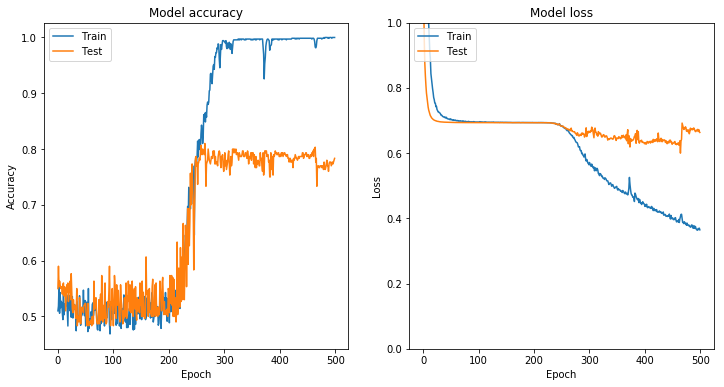

In [399]:
plot_metric_loss(history, 'binary_accuracy')

# ROC

In [341]:
from sklearn.metrics import roc_curve, auc

def roc_plot_keras(keras_model, X_data, y_data):
    
    y_score = keras_model.predict(X_data).ravel()
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_data.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

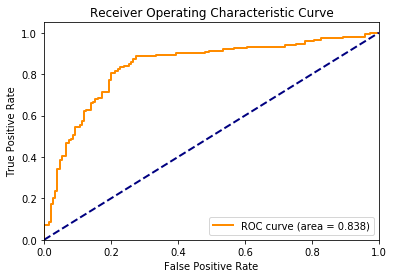

In [342]:
roc_plot_keras(model, X_test_indices, y_test.astype('int32'))